# Forecast the CocaCola prices. Prepare a document for each model explaining how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting. 

# Time series forecasting
        occurs when you make scientific predictions based on historical time stamped data. It involves building models through historical analysis and using them to make observations and drive future strategic decision-making
        
Time series can be decomposed into four components, each expressing a particular aspect of the movement of the values of the time series.

These four components are:

Secular trend, which describe the movement along the term;

Seasonal variations, which represent seasonal changes;

Cyclical fluctuations, which correspond to periodical but not seasonal variations;

Irregular variations, which are other nonrandom sources of variations of series 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

In [2]:
coke = pd.read_excel("CocaCola_Sales_Rawdata.xlsx")
coke.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


# Descriptive Statistics 

In [3]:
coke.isna().sum()

Quarter    0
Sales      0
dtype: int64

In [4]:
coke.duplicated().sum()

0

In [5]:
coke.shape

(42, 2)

In [6]:
coke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


# Feature Engineering

In [7]:
quarter = []
for i in range (0, len(coke)):
    if 'Q1' in coke.Quarter[i]:
        quarter.append('Q1')
    elif 'Q2' in coke.Quarter[i]:
        quarter.append('Q2')
    elif 'Q3' in coke.Quarter[i]:
        quarter.append('Q3')
    elif 'Q4' in coke.Quarter[i]:
        quarter.append('Q4') 
        
coke['quarter'] = quarter 

In [8]:
year = []

for i in range (0, len(coke)):
    year.append(int(coke.Quarter[i].replace(coke.Quarter[i][:3], ''))) 
    
coke['year'] = year 

In [9]:
coke.drop('Quarter', axis=1, inplace=True)

In [10]:
coke['log_sales'] = np.log(coke.Sales)

In [11]:
coke['t'] = np.arange(1,len(coke)+1) 

In [12]:
coke['t_squared'] = coke.t * coke.t 

In [13]:
coke1 = coke[['t', 't_squared', 'quarter', 'year', 'Sales', 'log_sales']] 

In [14]:
coke1 = pd.get_dummies(coke1) 
coke1.head()

,t,t_squared,year,Sales,log_sales,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4
0,1,1,86,1734.827000,7.458663,1,0,0,0
1,2,4,86,2244.960999,7.716443,0,1,0,0
2,3,9,86,2533.804993,7.837477,0,0,1,0
3,4,16,86,2154.962997,7.675529,0,0,0,1
4,5,25,87,1547.818996,7.344602,1,0,0,0


# Data Visualization 

<AxesSubplot:>

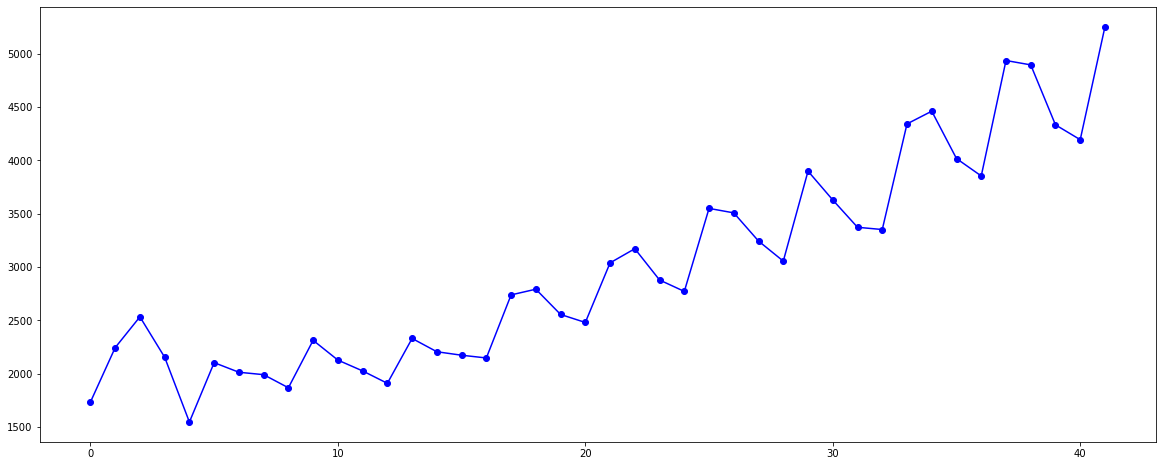

In [15]:
coke1.Sales.plot(figsize=(20, 8),color='blue',marker='o') 

We can observe increasing trend in sales 

<AxesSubplot:xlabel='year', ylabel='Sales'>

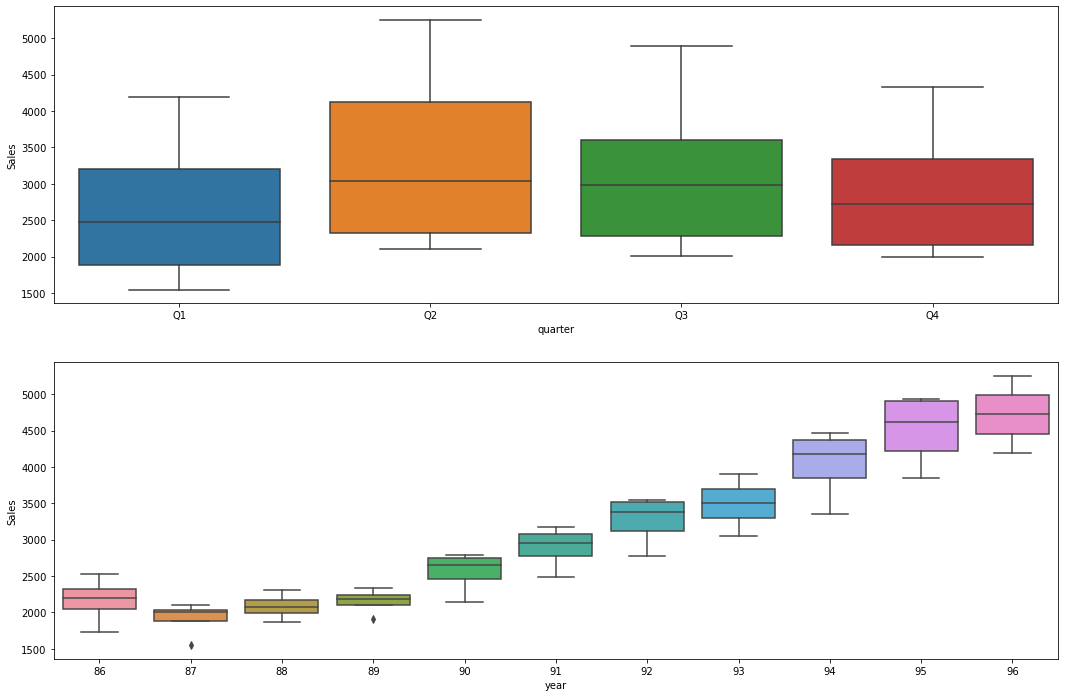

In [16]:
plt.figure(figsize=(18,12))

plt.subplot(2,1,1)
sns.boxplot(coke.quarter, coke.Sales)
plt.subplot(2,1,2)
sns.boxplot(coke.year, coke.Sales)

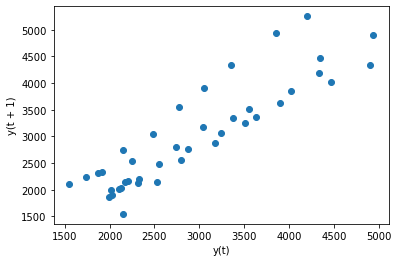

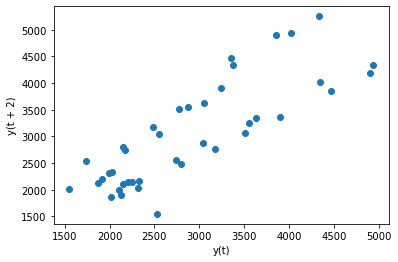

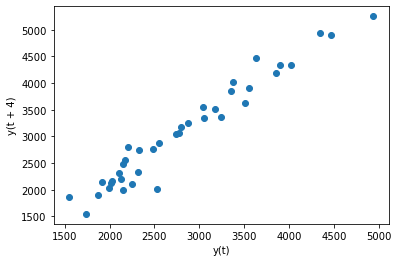

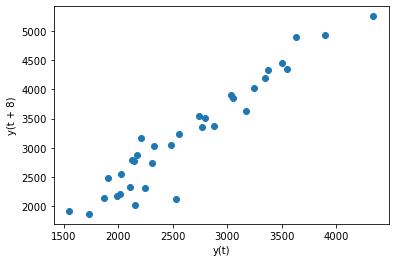

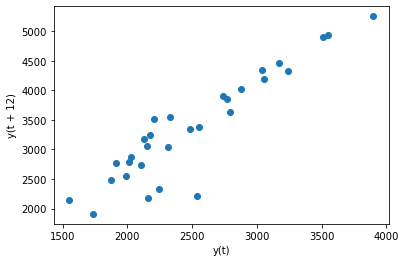

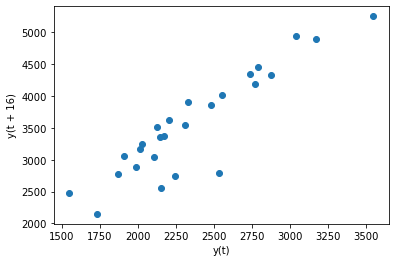

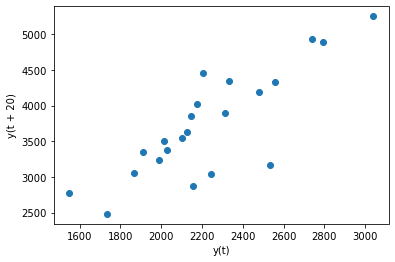

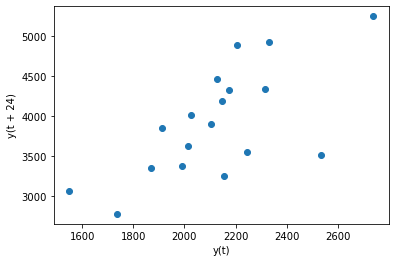

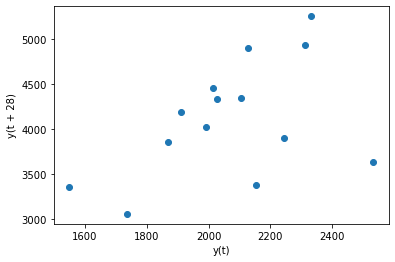

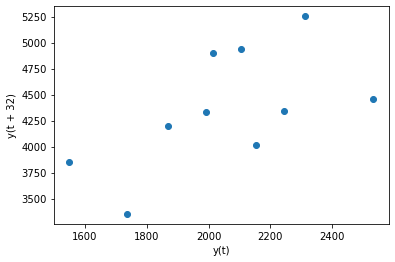

In [17]:
#Lag plot
from pandas.plotting import lag_plot

for i in [1, 2, 4, 8, 12, 16, 20, 24, 28, 32]:
    lag_plot(coke1.Sales, lag=i)
    plt.show() 

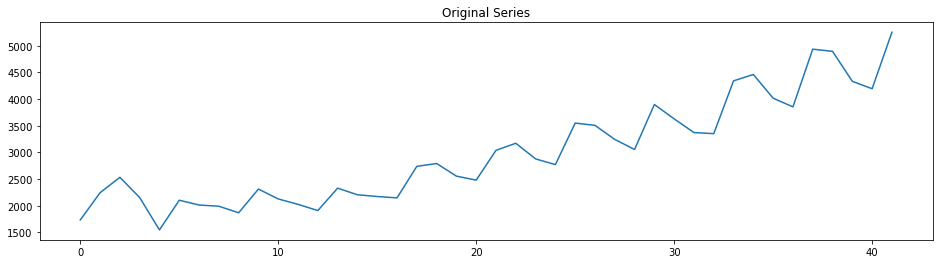

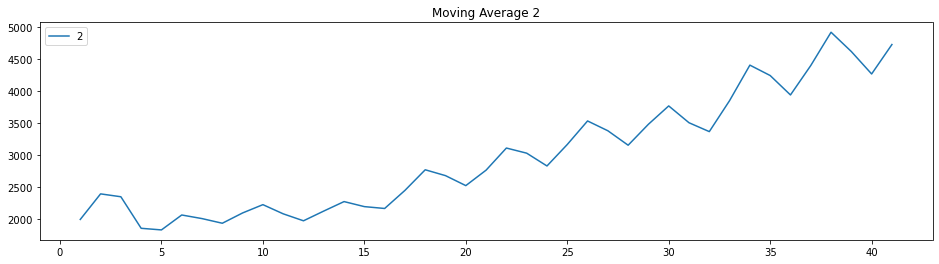

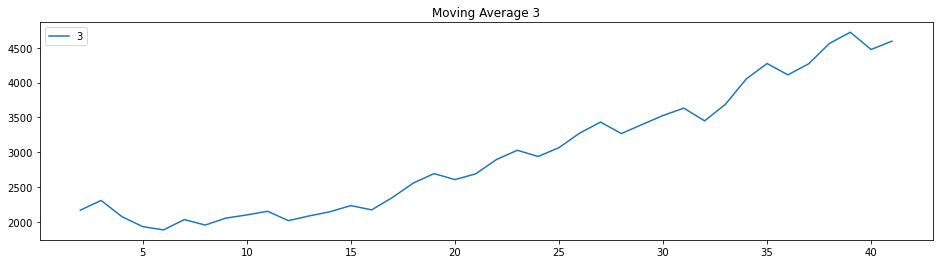

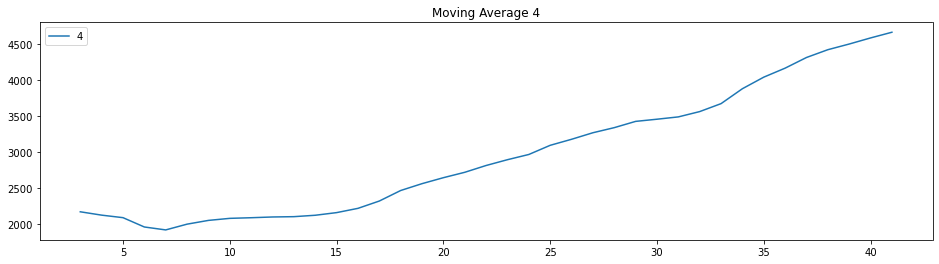

In [18]:
#Moving Average

plt.figure(figsize=(16,4))
coke.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,5):
    plt.figure(figsize=(16,4))
    coke["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show() 

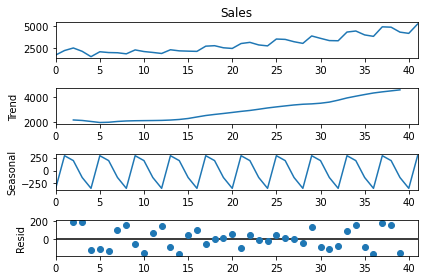

In [19]:
# Time series decomposition plot 
from statsmodels.tsa.seasonal import seasonal_decompose 

decompose_ts_add = seasonal_decompose(coke1.Sales,period=4)
decompose_ts_add.plot()
plt.show()

There is an upward trend in sales over the time. Though with some ups and downs. Also we can notice ups and downs are a bit regular, it indicates a seasonal pattern. 

### ACF plots and PACF plots:
        The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. The ACF plots the correlation coefficient against the lag, which is measured in terms of a number of periods or units.
        
The correlation coefficient can range from -1 (a perfect negative relationship) to +1 (a perfect positive relationship). A coefficient of 0 means that there is no relationship between the variables.

Partial autocorrelation is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables. 

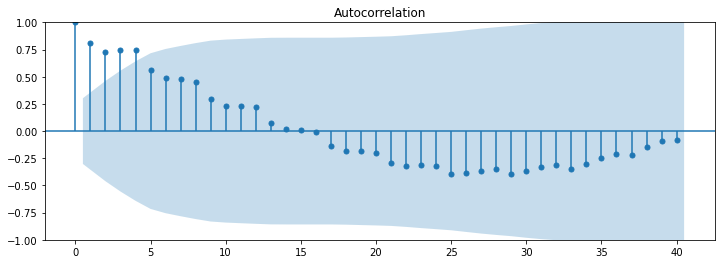

In [20]:
import statsmodels.graphics.tsaplots as tsa_plots
plt.rc("figure", figsize=(12,4)) 
tsa_plots.plot_acf(coke.Sales,lags=40)
plt.show()

Notice that for a lag zero, ACF is always equal to one, which makes sense because the signal is always perfectly correlated with itself.

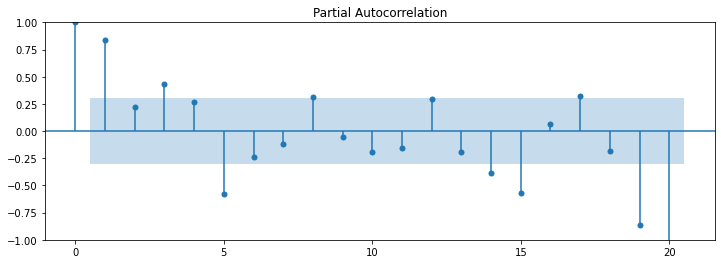

In [21]:
plt.rc("figure", figsize=(12,4))
tsa_plots.plot_pacf(coke.Sales,lags=20)
plt.show()

a partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself. 

# Forecasting: Model based methods

In [22]:
Train = coke1.head(32)
Test = coke1.tail(10) 

In [23]:
#Linear Model
import statsmodels.formula.api as smf 

linear_model = smf.ols('Sales~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_linear))**2))
rmse_linear

752.9233932767121

In [24]:
#Exponential

Exp = smf.ols('log_sales~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp


590.3316432076657

In [25]:
#Quadratic 

Quad = smf.ols('Sales~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_Quad))**2))
rmse_Quad

457.7357355407437

In [26]:
#Additive seasonality 

add_sea = smf.ols('Sales ~ quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[[ 'quarter_Q1' ,'quarter_Q2','quarter_Q3', 'quarter_Q4']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea 

1850.4665461858358

In [27]:
#Additive Seasonality Quadratic 

add_sea_Quad = smf.ols('Sales~t+t_squared+quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['quarter_Q1', 'quarter_Q2', 'quarter_Q3', 'quarter_Q4','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad 

277.3510771128639

In [28]:
##Multiplicative Seasonality

Mul_sea = smf.ols('log_sales~quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea 

1908.250394836118

In [29]:
#Multiplicative Additive Seasonality 

Mul_Add_sea = smf.ols('log_sales~t+quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Sales'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

448.8678182692097

In [30]:
#Compare the results 

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])  

,MODEL,RMSE_Values
4,rmse_add_sea_quad,277.351077
6,rmse_Mult_add_sea,448.867818
2,rmse_Quad,457.735736
1,rmse_Exp,590.331643
0,rmse_linear,752.923393
3,rmse_add_sea,1850.466546
5,rmse_Mult_sea,1908.250395


# Forecasting: Data Driven Models

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 

In [32]:
import math  
import sklearn.metrics 

In [33]:
def rmse(actual, pred):
    mse = sklearn.metrics.mean_squared_error(actual, pred)  
    rmse = math.sqrt(mse)
    return rmse 

In [34]:
# Simple Exponential Method
ses_model = SimpleExpSmoothing(Train["Sales"]).fit(smoothing_level=0.2)
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_ses = rmse(Test.Sales, pred_ses) 
rmse_ses

1172.1756457644592

In [35]:
# Holt method 
hw_model = Holt(Train["Sales"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
rmse_hw = rmse(Test.Sales, pred_hw) 
rmse_hw 

888.7798745682942

In [36]:
# Holts winter exponential smoothing with additive seasonality and additive trend
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4).fit() #add the trend to the model
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_hwe_add_add = rmse(Test.Sales, pred_hwe_add_add)
rmse_hwe_add_add

610.271136030792

In [37]:
# Holts winter exponential smoothing with multiplicative seasonality and additive trend
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit() 
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
rmse_mul_add =rmse(Test.Sales, pred_hwe_mul_add) 
rmse_mul_add

569.219834232828

In [38]:
#Compare the results 

data = {"MODEL":pd.Series(["linear","Exp","Quad","add_sea","add_sea_quad","Mult_sea","Mult_add_sea",'ses_model', 'hw_model', 'hwe_model_add_add', 'hwe_model_mul_add']),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea, rmse_ses, rmse_hw,rmse_hwe_add_add,rmse_mul_add  ])}
table_rmse=pd.DataFrame(data)

In [39]:
table_rmse = table_rmse.sort_values(by=['RMSE_Values']) 
table_rmse 

,MODEL,RMSE_Values
4,add_sea_quad,277.351077
6,Mult_add_sea,448.867818
2,Quad,457.735736
10,hwe_model_mul_add,569.219834
1,Exp,590.331643
9,hwe_model_add_add,610.271136
0,linear,752.923393
8,hw_model,888.779875
7,ses_model,1172.175646
3,add_sea,1850.466546


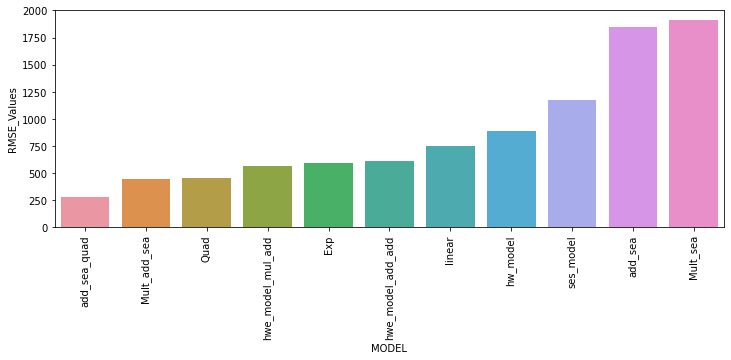

In [40]:
sns.barplot(table_rmse.MODEL , table_rmse.RMSE_Values)
plt.xticks(rotation = 90)
plt.show()

# Final Model by combining train and test

In [41]:
add_sea_Quad = smf.ols('Sales~t+t_squared+quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data=coke1).fit()
pred= add_sea_Quad.predict(coke1.tail()) #predicting on historic data

In [42]:
forecast_df = pd.DataFrame()

forecast_df['actual_sales'] = coke1.Sales.tail()
forecast_df['Predicted_sales'] = pred 

forecast_df 

,actual_sales,Predicted_sales
37,4936.0,4705.724784
38,4895.0,4753.588072
39,4333.0,4557.724974
40,4194.0,4475.373006
41,5253.0,5257.826846


In [43]:
#creating new inputs for forecasting
new_df = pd.DataFrame() 
new_df['t'] = np.arange(43,50,1) 
new_df['t_squared'] = np.square(new_df.t)
new_df['quarter'] = ['Q3', 'Q4', 'Q1', 'Q2', 'Q3', 'Q4', 'Q1'] 
new_df = pd.get_dummies(new_df)
new_df 

,t,t_squared,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4
0,43,1849,0,0,1,0
1,44,1936,0,0,0,1
2,45,2025,1,0,0,0
3,46,2116,0,1,0,0
4,47,2209,0,0,1,0
5,48,2304,0,0,0,1
6,49,2401,1,0,0,0


In [44]:
add_sea_Quad = smf.ols('Sales~t+t_squared+quarter_Q1 + quarter_Q2+ quarter_Q3+ quarter_Q4',data=coke1).fit()
pred= add_sea_Quad.predict(new_df)  

new_df['forcasted'] = pred

new_df 

,t,t_squared,quarter_Q1,quarter_Q2,quarter_Q3,quarter_Q4,forcasted
0,43,1849,0,0,1,0,5319.754557
1,44,1936,0,0,0,1,5137.955882
2,45,2025,1,0,0,0,5069.668337
3,46,2116,0,1,0,0,5866.186600
4,47,2209,0,0,1,0,5942.178733
5,48,2304,0,0,0,1,5774.444481
6,49,2401,1,0,0,0,5720.221359


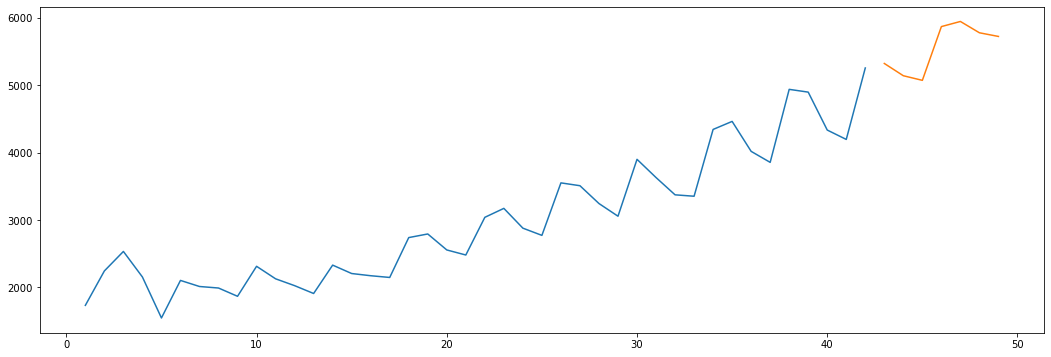

In [45]:
plt.figure(figsize=(18,6))
plt.plot(coke1.t , coke1.Sales)
plt.plot(new_df.t , new_df.forcasted)

### We created dummy variables for quarter feature and final model is based on Additive seasonality Quadratic. 

# Thank You 